# Colombians migration data analysis

## librerías, carga de datos  y primera inspección

In [1]:
# Carga de dataset en base de datos PostgreSQL
import pandas as pd
from sqlalchemy import create_engine
import json

# Visualización y análisis de datos
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paleta de colores a usar en los gráficos
palette_custom = [
    "#2C69B0FF", "#B5C8E2FF", "#F02720FF", "#FFB6B0FF",
    "#AC613CFF", "#E9C39BFF", "#6BA3D6FF", "#B5DFFDFF",
    "#AC8763FF", "#DDC9B4FF", "#BD0A36FF", "#F4737AFF"
]

def ajustar_palette(data, col_categoria, palette):
    num_categorias = data[col_categoria].nunique()
    return palette[:num_categorias]

Cargaremos el **conjunto de datos** (dataset) desde **PostgreSQL** para:

1.  Verificar si los datos requieren una **limpieza** adicional.
2.  Realizar un **Análisis Exploratorio de Datos (EDA)**.
3.  Responder preguntas específicas sobre la **migración colombiana** a través de **aeropuertos internacionales**, empleando **análisis y visualizaciones** en Python.

In [2]:
with open('../config.json') as f:
    config = json.load(f)
db = config["database"]

# Crear la conexión
engine = create_engine(
    f"postgresql://{db['user']}:{db['password']}@{db['host']}:{db['port']}/{db['dbname']}")

# Leer la tabla limpia desde PostgreSQL
df = pd.read_sql("SELECT * FROM registro_aeropuerto", engine, parse_dates=['fecha_de_registro'])

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   pais                   200000 non-null  object        
 1   codigo_iso_pais        200000 non-null  object        
 2   ciudad_de_residencia   200000 non-null  object        
 3   oficina_de_registro    200000 non-null  object        
 4   grupo_edad             200000 non-null  object        
 5   edad_anios             199719 non-null  float64       
 6   area_conocimiento      200000 non-null  object        
 7   sub_area_conocimiento  200000 non-null  object        
 8   nivel_academico        200000 non-null  object        
 9   estado_civil           200000 non-null  object        
 10  genero                 200000 non-null  object        
 11  etnia_de_la_persona    200000 non-null  object        
 12  estatura_cm            35658 non-null   floa

,pais,codigo_iso_pais,ciudad_de_residencia,oficina_de_registro,grupo_edad,edad_anios,area_conocimiento,sub_area_conocimiento,nivel_academico,estado_civil,genero,etnia_de_la_persona,estatura_cm,ciudad_de_nacimiento,fecha_de_registro,cantidad_de_personas,latitud,longitud
0,ESPAÑA,ESP,VIZCAYA/BILBAO,C. BILBAO,ADULTOS MAYORES,64.0,NO INDICA,NO INDICA,BACHILLERATO,SOLTERO,FEMENINO,NINGUNA,159.0,COLOMBIA/VALLE DEL CAUCA/CALI,2015-09-01,1,40.463667,-3.749220
1,ESPAÑA,ESP,EXTREMADURA/CACERES,C. SEVILLA,ADULTOS,34.0,NINGUNA,NINGUNA,BACHILLERATO,SOLTERO,MASCULINO,NINGUNA,186.0,COLOMBIA/ANTIOQUIA/MEDELLIN,2024-02-01,1,40.463667,-3.749220
2,REINO UNIDO,GBR,LINCOLNSHIRE/LINCOLN,C. LONDRES,ADOLESCENCIA,17.0,NO INDICA,NO INDICA,PRIMARIA,SOLTERO,MASCULINO,OTRO,115.0,REINO UNIDO/LONDRES/LONDRES,2015-10-01,1,55.378051,-3.435973
3,ESPAÑA,ESP,MADRID/MAJADAHONDA,C. MADRID,ADULTOS,42.0,NO INDICA,NO INDICA,BACHILLERATO,SOLTERO,MASCULINO,NINGUNA,160.0,COLOMBIA/VALLE DEL CAUCA/FLORIDA,2015-09-01,1,40.463667,-3.749220
4,VENEZUELA,VEN,ZULIA/MARACAIBO,C. MARACAIBO,ADULTOS,37.0,NO INDICA,NO INDICA,BACHILLERATO,UNION_LIBRE,MASCULINO,OTRO,169.0,COLOMBIA/TOLIMA/IBAGUE,2014-11-01,1,6.423750,-66.589730


## Limpieza de datos

Como primer paso de la limpieza de datos, observamos que las columnas **'edad_anios'** y **'estatura_cm'** no pudieron convertirse al tipo de dato **`int64`**, a diferencia de la columna **'cantidad_de_personas'**. Esto se debe a la presencia de **valores nulos** en algunas de sus filas.

Para resolver esto, realizaremos el siguiente proceso de **imputación**:

1. **Columna `edad_anios`:** Para imputar los valores nulos en esta columna, nos enfocaremos en la columna **'grupo_edad'**:

* Imputaremos los valores nulos con la **media de años** correspondiente a su respectivo grupo etario.
* Si el valor de **'grupo_edad'** es **'DESCONOCIDO'**, imputaremos el nulo con el valor **0**.

---

2. **Columna `estatura_cm`:** Para imputar los valores nulos en esta columna, consideraremos las columnas **'grupo_edad'** y **'genero'**, ya que la estatura puede variar significativamente entre géneros dentro del mismo grupo etario:

* Imputaremos los valores nulos con la **media de estatura** correspondiente a la combinación específica de **'grupo_edad'** y **'genero'**.
* Si el valor de **'grupo_edad'** o **'genero'** es **'DESCONOCIDO'**, imputaremos el nulo con el valor **0**.

---

3. **Cambio de Tipo de Dato:** Finalmente, una vez imputados los nulos, **cambiaremos el tipo de dato** de las columnas **'edad_anios'** y **'estatura_cm'** a **`int64`** para asegurar la consistencia del *dataset*.

---

4. **Corrección de palabras con el símbolo `�`:** Durante la revisión inicial se identificó la presencia del símbolo **`�`** en algunas palabras, producto de errores de codificación que impidieron detectar tildes y caracteres como la **ñ**. Para corregirlo:

* Se implementará una **función especializada** que buscará todas las palabras que contengan el símbolo **`�`**.
* Cada palabra detectada será reemplazada mediante una **imputación del carácter correcto**, restaurando tildes y letras perdidas (como la **ñ**) según corresponda.

Esta corrección asegura una adecuada interpretación de textos y categorías en el *dataset*.

In [3]:
df.groupby("grupo_edad")["edad_anios"].apply(lambda x: x.isnull().sum()).reset_index(name="nulls_edad_anios")

,grupo_edad,nulls_edad_anios
0,ADOLESCENCIA,0
1,ADULTOS,0
2,ADULTOS JOVENES,0
3,ADULTOS MAYORES,0
4,DESCONOCIDO,281
5,INFANCIA,0
6,PRIMERA INFANCIA,0


Hemos identificado que **todos los valores nulos** en la columna **'edad_anios'** corresponden al grupo etario **'DESCONOCIDO'**.

Por lo tanto, procederemos a **imputar todos esos nulos con el valor 0**.

In [4]:
df['edad_anios'] = df['edad_anios'].fillna(0)
print('Cantidad de filas con nulos transformados: ', df['edad_anios'].isnull().sum())

Cantidad de filas con nulos transformados:  0


In [5]:
df.groupby(['grupo_edad','genero'])['estatura_cm'].apply(lambda x: x.isnull().sum()).reset_index(name='nulls_estatura_cm')

,grupo_edad,genero,nulls_estatura_cm
0,ADOLESCENCIA,DESCONOCIDO,3
1,ADOLESCENCIA,FEMENINO,2028
2,ADOLESCENCIA,MASCULINO,2089
3,ADOLESCENCIA,NO_BINARIO,1
4,ADULTOS,DESCONOCIDO,75
5,ADULTOS,FEMENINO,56829
6,ADULTOS,MASCULINO,47701
7,ADULTOS JOVENES,DESCONOCIDO,10
8,ADULTOS JOVENES,FEMENINO,11958
9,ADULTOS JOVENES,MASCULINO,11867


Al revisar la tabla, notamos la presencia de **valores nulos** en la columna **'estatura_cm'**. Estos nulos pueden ser clasificados y tratados para **reducir su impacto** y mantener la integridad de los datos.

Por lo tanto, procederemos a la **imputación** de la siguiente manera:

* Calcularemos la **media de la estatura** (`estatura_cm`) para cada **combinación única de 'grupo_edad' y 'genero'**.
* Imputaremos los valores nulos de `estatura_cm` con la media correspondiente a su respectivo grupo.

De esta forma, aprovechamos la influencia del **género** en la estatura dentro de cada **grupo etario** para realizar una imputación más precisa.

In [6]:
# Calculo de la media segun las columnas categoricas
df_filtrado = df[(df['grupo_edad'] != 'DESCONOCIDO') & (df['genero'] != 'DESCONOCIDO') & (df['estatura_cm'].notnull())]

resultado = ( df_filtrado.groupby(['grupo_edad', 'genero'])['estatura_cm'].mean().round()
    .reset_index(name='media_estatura_cm'))

display(resultado)
print('Cantidad de filas con nulos:', df['estatura_cm'].isnull().sum())

#Imputacion de la media a datos null
df['estatura_cm'] = df['estatura_cm'].fillna(
    df.groupby(['grupo_edad', 'genero'])['estatura_cm'].transform('mean').round())

print('Cantidad de filas con nulos restantes: ', df['estatura_cm'].isnull().sum())

,grupo_edad,genero,media_estatura_cm
0,ADOLESCENCIA,FEMENINO,110.0
1,ADOLESCENCIA,MASCULINO,111.0
2,ADULTOS,FEMENINO,161.0
3,ADULTOS,MASCULINO,173.0
4,ADULTOS JOVENES,FEMENINO,155.0
5,ADULTOS JOVENES,MASCULINO,162.0
6,ADULTOS MAYORES,FEMENINO,159.0
7,ADULTOS MAYORES,MASCULINO,170.0
8,INFANCIA,FEMENINO,75.0
9,INFANCIA,MASCULINO,80.0


Cantidad de filas con nulos: 164342
Cantidad de filas con nulos restantes:  808


In [7]:
df['estatura_cm'] = df['estatura_cm'].fillna(0)
print('Cantidad de filas con nulos: ', df['estatura_cm'].isnull().sum())

Cantidad de filas con nulos:  0


Una vez finalizado el proceso de **imputación de todos los valores nulos**, procederemos al **cambio de Tipo de Dato** de las columnas **'edad_anios'** y **'estatura_cm'** al formato **`int64`** para asegurar la consistencia numérica.

In [8]:
df['edad_anios'] = df['edad_anios'].astype('int64')
df['estatura_cm'] = df['estatura_cm'].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   pais                   200000 non-null  object        
 1   codigo_iso_pais        200000 non-null  object        
 2   ciudad_de_residencia   200000 non-null  object        
 3   oficina_de_registro    200000 non-null  object        
 4   grupo_edad             200000 non-null  object        
 5   edad_anios             200000 non-null  int64         
 6   area_conocimiento      200000 non-null  object        
 7   sub_area_conocimiento  200000 non-null  object        
 8   nivel_academico        200000 non-null  object        
 9   estado_civil           200000 non-null  object        
 10  genero                 200000 non-null  object        
 11  etnia_de_la_persona    200000 non-null  object        
 12  estatura_cm            200000 non-null  int6

A continuación, se procederá a crear una **función para detectar el símbolo `�`** dentro de las palabras presentes en el *dataset*. Una vez identificadas, dichas palabras serán reemplazadas utilizando un **diccionario en formato JSON**, donde se especificará la versión corregida de cada término.

In [9]:
def detectar_palabras_con_simbolo(df, columna, simbolo="�"):
    
    if columna not in df.columns:
        raise ValueError(f"La columna '{columna}' no existe en el DataFrame.")
    
    if df[columna].dtype != "object":
        raise TypeError(f"La columna '{columna}' no es categórica (tipo object).")

    # Filtrar valores que contengan el símbolo
    palabras = (df[df[columna].astype(str).str.contains(simbolo, na=False)][columna].unique().tolist())

    return palabras

In [10]:
detectar_palabras_con_simbolo(df, columna='oficina_de_registro')

correciones_oficina_de_registro = {
    'C. PUERTO ESPA�A': 'C. PUERTO ESPAÑA',
    'C. BAK�': 'C. BAKU'
}
df['oficina_de_registro'] = df['oficina_de_registro'].replace(correciones_oficina_de_registro)

In [11]:
detectar_palabras_con_simbolo(df, columna='area_conocimiento')

correcciones_area_conocimiento = {
  "INGENIER�A, ARQUITECTURA Y AFINES": "INGENIERIA, ARQUITECTURA Y AFINES",
  "ECONOM�A, ADMINISTRACI�N CONTADURIA Y AFINES": "ECONOMIA, ADMINISTRACION CONTADURIA Y AFINES",
  "AVIACI�N": "AVIACION",
  "MATEM�TICAS Y CIENCIAS NATURALES": "MATEMATICAS Y CIENCIAS NATURALES",
  "CIENCIAS DE LA EDUCACI�N": "CIENCIAS DE LA EDUCACION",
  "AGRONOM�A, VETERINARIA Y ZOOTECNIA": "AGRONOMIA, VETERINARIA Y ZOOTECNIA",
  "AGRONOM�A, VETERINARIA Y AFINES": "AGRONOMIA, VETERINARIA Y AFINES",
  "ADMINISTRACI�N DE EMPRESAS Y DERECHO": "ADMINISTRACION DE EMPRESAS Y DERECHO",
  "INGENIER�A, INDUSTRIA Y CONSTRUCCI�N": "INGENIERIA, INDUSTRIA Y CONSTRUCCION",
  "CIENCIAS NATURALES, MATEM�TICAS Y ESTAD�STICA": "CIENCIAS NATURALES, MATEMATICAS Y ESTADISTICA",
  "CIENCIAS SOCIALES, PERIODISMO E INFORMACI�N": "CIENCIAS SOCIALES, PERIODISMO E INFORMACION",
  "EDUCACI�N": "EDUCACION",
  "PROGRAMAS Y CERTIFICACIONES GEN�RICAS": "PROGRAMAS Y CERTIFICACIONES GENERICAS",
  "TECNOLOG�AS DE LA INFORMACI�N Y LA COMUNICACI�N (TIC)": "TECNOLOGIAS DE LA INFORMACION Y LA COMUNICACION (TIC)"
}
df['area_conocimiento'] = df['area_conocimiento'].replace(correcciones_area_conocimiento)

In [12]:
detectar_palabras_con_simbolo(df, columna='sub_area_conocimiento')

correcciones_sub_area_conocimiento = {
    'BACTERIOLOG�A': 'BACTERIOLOGIA',
    'INGENIER�A CIVIL Y AFINES': 'INGENIERIA CIVIL Y AFINES',
    'ADMINISTRACI�N': 'ADMINISTRACION',
    'INGENIER�A ELECTR�NICA, TELECOMUNICACIONES Y AFINES': 'INGENIERIA ELECTRONICA, TELECOMUNICACIONES Y AFINES',
    'CONTADUR�A P�BLICA': 'CONTADURIA PUBLICA',
    'ENFERMER�A': 'ENFERMERIA',
    'INGENIER�A EL�CTRICA Y AFINES': 'INGENIERIA ELECTRICA Y AFINES',
    'PERIODISMO, COMUNICACI�N SOCIAL Y AFINES': 'PERIODISMO, COMUNICACION SOCIAL Y AFINES',
    'OPTOMETR�A': 'OPTOMETRIA',
    'AVIACI�N': 'AVIACION',
    'ECONOM�A': 'ECONOMIA',
    'INGENIER�A INDUSTRIAL Y AFINES': 'INGENIERIA INDUSTRIAL Y AFINES',
    'MATEM�TICAS, ESTAD�STICA Y AFINES': 'MATEMATICAS, ESTADISTICA Y AFINES',
    'EDUCACI�N': 'EDUCACION',
    'SOCIOLOG�A, TRABAJO SOCIAL Y AFINES': 'SOCIOLOGIA, TRABAJO SOCIAL Y AFINES',
    'PSICOLOG�A Y AFINES': 'PSICOLOGIA Y AFINES',
    'INSTRUMENTACI�N QUIR�RGICA': 'INSTRUMENTACION QUIRURGICA',
    'OTRAS INGENIER�AS': 'OTRAS INGENIERIAS',
    'INGENIER�A QU�MICA Y AFINES': 'INGENIERIA QUIMICA Y AFINES',
    'INGENIER�A MEC�NICA Y AFINES': 'INGENIERIA MECANICA Y AFINES',
    'INGENIER�A EN SISTEMAS, TELEM�TICA Y AFINES': 'INGENIERIA EN SISTEMAS, TELEMATICA Y AFINES',
    'SALUD P�BLICA': 'SALUD PUBLICA',
    'ARTES PL�STICAS, VISUALES Y AFINES': 'ARTES PLASTICAS, VISUALES Y AFINES',
    'LENGUAS MODERNAS, FILOLOG�A, LING��STICA Y AFINES': 'LENGUAS MODERNAS, FILOLOGIA, LINGUISTICA Y AFINES',
    'DISE�O': 'DISENO',
    'ODONTOLOG�A': 'ODONTOLOGIA',
    'INGENIER�A AGROINDUSTRIAL, ALIMENTOS Y AFINES': 'INGENIERIA AGROINDUSTRIAL, ALIMENTOS Y AFINES',
    'GEOLOG�A': 'GEOLOGIA',
    'INGENIER�A AMBIENTAL, SANITARIA Y AFINES': 'INGENIERIA AMBIENTAL, SANITARIA Y AFINES',
    'ANTROPOLOG�A O ARTES LIBERALES': 'ANTROPOLOGIA O ARTES LIBERALES',
    'CIENCIA POL�TICA Y/O RELACIONES INTERNACIONALES': 'CIENCIA POLITICA Y/O RELACIONES INTERNACIONALES',
    'F�SICA': 'FISICA',
    'FILOSOF�A, TEOLOG�A Y AFINES': 'FILOSOFIA, TEOLOGIA Y AFINES',
    'INGENIER�A BIOM�DICA Y AFINES': 'INGENIERIA BIOMEDICA Y AFINES',
    'AGRONOM�A': 'AGRONOMIA',
    'BIOLOG�A, MICROBIOLOG�A Y AFINES': 'BIOLOGIA, MICROBIOLOGIA Y AFINES',
    'INGENIER�A DE PETR�LEOS': 'INGENIERIA DE PETROLEOS',
    'M�SICA': 'MUSICA',
    'GEOGRAF�A O HISTORIA': 'GEOGRAFIA O HISTORIA',
    'QU�MICA Y AFINES': 'QUIMICA Y AFINES',
    'NUTRICI�N Y DIET�TICA': 'NUTRICION Y DIETETICA',
    'INGENIER�A ADMINISTRATIVA Y AFINES': 'INGENIERIA ADMINISTRATIVA Y AFINES',
    'INGENIER�A AGR�COLA, FORESTAL Y AFINES': 'INGENIERIA AGRICOLA, FORESTAL Y AFINES',
    'TECNOLOG�AS DE LA INFORMACI�N Y LA COMUNICACI�N (TIC)': 'TECNOLOGIAS DE LA INFORMACION Y LA COMUNICACION (TIC)',
    'ARTES DRAM�TICAS Y REPRESENTATIVAS': 'ARTES DRAMATICAS Y REPRESENTATIVAS',
    'FORMACI�N MILITAR': 'FORMACION MILITAR',
    'INGENIER�A DE MINAS, METALURGIA Y AFINES': 'INGENIERIA DE MINAS, METALURGIA Y AFINES',
    'INGENIER�A AGRON�MICA, PECUARIA Y AFINES': 'INGENIERIA AGRONOMICA, PECUARIA Y AFINES',
    'BIBLIOTECOLOG�A': 'BIBLIOTECOLOGIA',
    'DEPORTES, EDUCACI�N F�SICA Y RECREACI�N': 'DEPORTES, EDUCACION FISICA Y RECREACION'
}
df['sub_area_conocimiento'] = df['sub_area_conocimiento'].replace(correcciones_sub_area_conocimiento)

In [13]:
detectar_palabras_con_simbolo(df, columna='nivel_academico')

correcciones_nivel_academico = {
  "PREGRADO - T�CNICO PROFESIONAL": "PREGRADO - TECNICO PROFESIONAL",
  "POSTGRADO - ESPECIALIZACI�N": "POSTGRADO - ESPECIALIZACION",
  "PREGRADO - TECNOL�GICO": "PREGRADO - TECNOLOGICO",
  "SIN PROFESI�N": "SIN PROFESION"
}
df['nivel_academico'] = df['nivel_academico'].replace(correcciones_nivel_academico)

In [14]:
detectar_palabras_con_simbolo(df, columna='etnia_de_la_persona')

correciones_etnia_de_la_persona = {'IND�GENA': 'INDIGENA'}
df['etnia_de_la_persona'] = df['etnia_de_la_persona'].replace(correciones_etnia_de_la_persona)

Después de realizar las correcciones correspondientes, se decidió dejar por fuera las columnas **'Ciudad_de_nacimiento'** y **'ciudad_de_residencia'**. Ambas presentan una **gran cantidad de valores que contienen el símbolo `�`**, lo que implicaría un tiempo considerable para reemplazarlos manual o programáticamente.
Por este motivo, **se conservarán tal como están** en esta fase del proceso.

Finalmente, se creará una **copia del *dataset* ya limpio** (o transformado). Esta copia será utilizada como la base de datos final para iniciar el **Análisis Exploratorio de Datos (EDA)** y el desarrollo de las visualizaciones.


In [15]:
df_processing = df.copy()

## Inicio del Análisis Exploratorio de Datos

### Análisis univariable

Tras completar la carga y **limpieza de los datos**, el objetivo principal de esta fase es extraer **información relevante** para entender los patrones de viaje.

Comenzaremos el análisis exploratorio examinando el comportamiento de **variables individuales** que puedan ser relevantes por sí solas, como la **columna de país de destino**. A partir de este análisis inicial, desarrollaremos la investigación para identificar los flujos migratorios más importantes.

Nos enfocaremos en analizar las **características clave** del *dataset* para identificar los factores que influyen en la elección del **destino** por parte de los colombianos.

Este análisis nos permitirá:

* Descubrir **por qué** ciertas personas viajan con más frecuencia o prefieren un destino sobre otro (por ejemplo: por edad, género, o mes del año).
* Generar **visualizaciones de datos** (gráficos) que ilustren de forma clara y concisa las distribuciones y las correlaciones encontradas.

Con esto, podremos empezar a **responder preguntas específicas** sobre la migración colombiana al exterior.

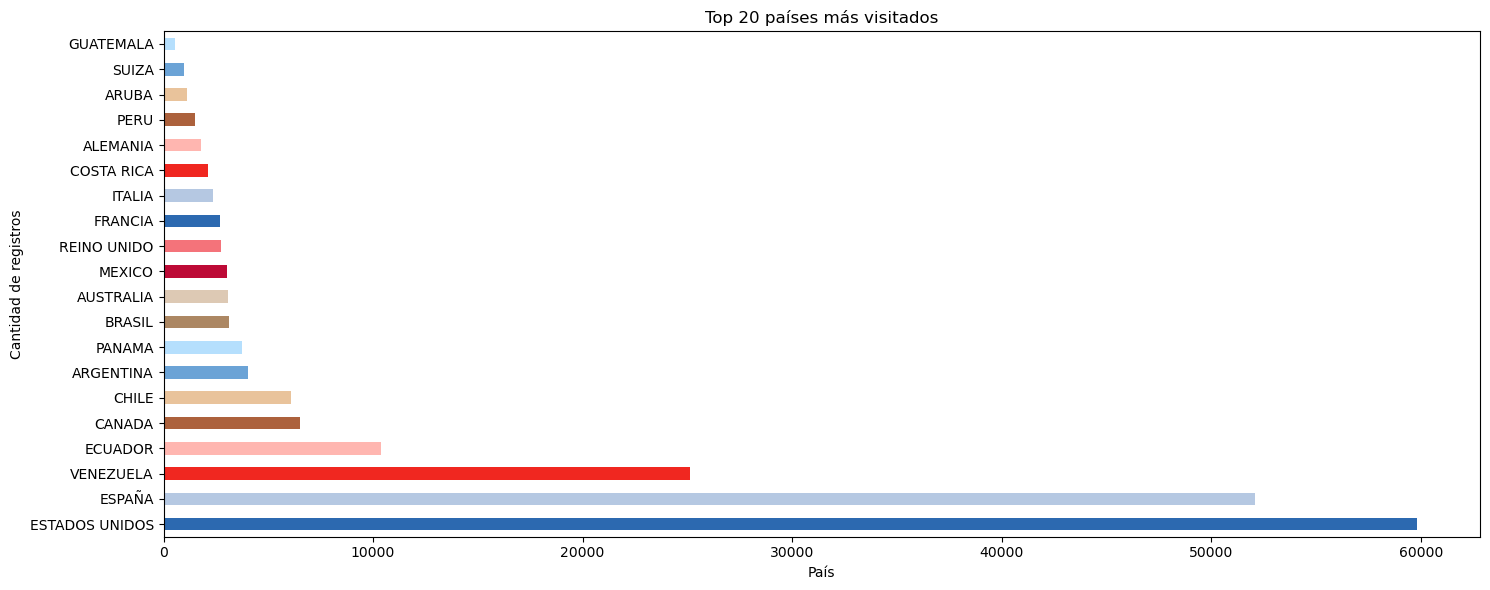

In [16]:
top_20_paises = df_processing['pais'].value_counts().head(20)

plt.figure(figsize=(15, 6))
top_20_paises.plot(kind='barh', color=palette_custom)

plt.title('Top 20 países más visitados')
plt.xlabel('País')
plt.ylabel('Cantidad de registros')
plt.tight_layout()
plt.show()

Como parte del análisis de **variables individuales**, se presenta la tabla con los **20 países más visitados** por los viajeros colombianos para obtener un contexto inicial.

Esta exploración **confirma** los hallazgos de las consultas previas de **SQL**, mostrando que los tres destinos más frecuentados son, por orden:

1.  **Estados Unidos**
2.  **España**
3.  **Venezuela**

A continuación, iniciaremos la exploración de la columna **'grupo_edad'**. El objetivo es determinar **qué grupos etarios tienen la mayor propensión a viajar al exterior**, independientemente de su destino. Al analizar la distribución, podremos identificar qué **tipo de personas (por rango de edad)** concentran el mayor flujo migratorio colombiano.

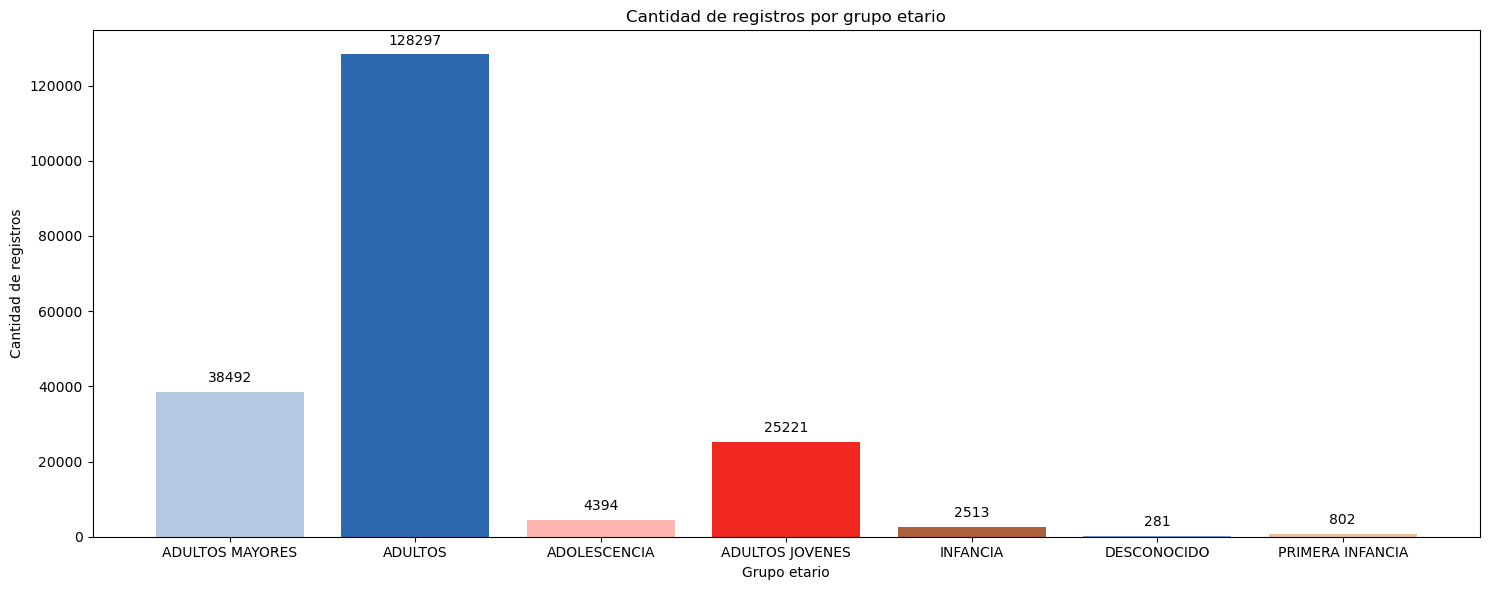

In [17]:
conteos_grupo_edad = df_processing['grupo_edad'].value_counts()
palette = ajustar_palette(df_processing, 'grupo_edad', palette_custom)

plt.figure(figsize=(15, 6))
g = sns.countplot(data = df_processing, x ='grupo_edad', hue = 'grupo_edad')
conteo_total = g.bar(conteos_grupo_edad.index, conteos_grupo_edad.values, color=palette)
g.bar_label(conteo_total, fmt='%d', padding=5, fontsize=10)

plt.title('Cantidad de registros por grupo etario')
plt.xlabel('Grupo etario')
plt.ylabel('Cantidad de registros')
plt.tight_layout()
plt.show()

### Análisis grupo etario ADULTOS

El análisis univariado de la columna **'grupo_edad'** confirma que los tres grupos de adultos ('ADULTOS', 'ADULTOS MAYORES' y 'ADULTOS JOVENES') concentran la mayor parte de los viajes al exterior. El grupo **'ADULTOS'** destaca significativamente, superando con creces a las demás categorías.

Este dato nos permite inferir que las **personas en edad productiva y avanzada** son, en general, las que más se desplazan al exterior.

A partir de este hallazgo, surge una pregunta clave sobre la **motivación** detrás de estos viajes:

* **¿Cuál es la distribución detallada de las edades** dentro de cada uno de los grupos etarios identificados?
* ¿La migración de adultos se debe a **la obtención de mejores oportunidades laborales en el exterior** (asociado a una alta formación académica), o es el resultado de **la falta de oportunidades en el país de origen** (asociado a una escasa formación académica)?

Para responder a esta hipótesis, el siguiente paso será analizar la distribución de edades dentro de cada grupo etario mediante **diagramas de caja (box plots)**. Esto nos permitirá observar la **dispersión y concentración** de las edades en cada categoría.

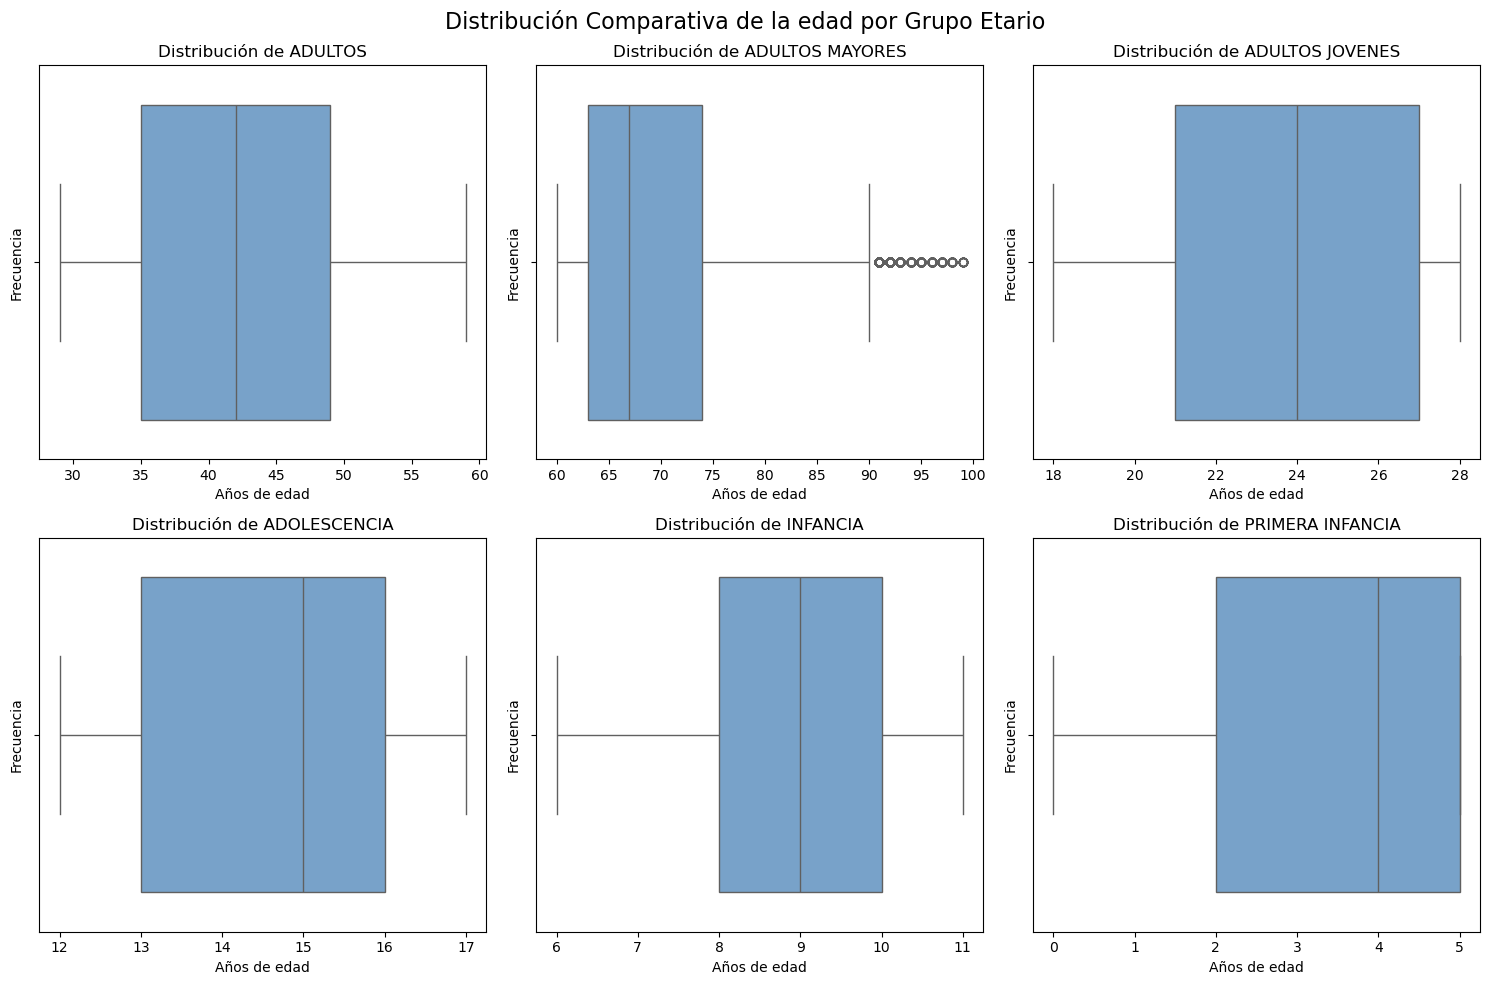

In [18]:
grupos_edad = ['ADULTOS', 'ADULTOS MAYORES', 'ADULTOS JOVENES', 'ADOLESCENCIA', 'INFANCIA', 'PRIMERA INFANCIA']

fig, axs = plt.subplots(2, 3, figsize=(15, 10)) 
axs = axs.flatten()

for i, grupo in enumerate(grupos_edad):
    data_grupo_edad = df_processing[df_processing['grupo_edad'] == grupo]
    sns.boxplot(data=data_grupo_edad, x='edad_anios', ax=axs[i], color='#6BA3D6FF')
    
    axs[i].set_title(f'Distribución de {grupo}', fontsize=12)
    axs[i].set_xlabel('Años de edad')
    axs[i].set_ylabel('Frecuencia')
 
plt.suptitle(f'Distribución Comparativa de la edad por Grupo Etario', fontsize=16)
plt.tight_layout()
plt.show()

La visualización de los *Box Plots* (diagramas de caja) proporciona un detalle claro de la distribución interna de las edades dentro de cada uno de los seis grupos etarios del *dataset*.

### Grupos Etarios Adultos (Rango Productivo)
Los grupos de **ADULTOS** (29 y 59 años) y **ADULTOS JÓVENES** (18 y 28 años) muestran una distribución **concentrada y simétrica**. Esto indica que la mayoría de los viajeros de estos grupos se encuentran en la **mitad de su respectivo rango de edad**, es decir, en los primeros años de la edad productiva para los jóvenes (mediana alrededor de 24 años) y en la mitad de la edad productiva para los adultos (mediana alrededor de 43 años). Por su parte, el grupo de **ADULTOS MAYORES** (aproximadamente entre 60 y 99 años) presenta una distribución poco concentrada. Tambien, se observan **valores atípicos (*outliers*)** en el extremo superior (cercanos a 100 años).

### Grupos Etarios Jóvenes (Rango No Productivo)
Los grupos de **ADOLESCENCIA** (12 a 17 años), **INFANCIA** (6 a 11 años) y **PRIMERA INFANCIA** (0 a 5 años) presentan distribuciones de edad muy simétricas y **extremadamente concentradas**. La baja dispersión en estos diagramas de caja es un indicador positivo, pues confirma que las edades se ajustan de manera precisa a los rangos estrictamente definidos para estas categorías.

### Conclusión
El análisis visual ratifica que cada grupo etario está bien delimitado y que la edad de los viajeros se concentra en los rangos esperados para cada categoría. Esto proporciona una **base de datos consistente** para los análisis multivariados realizados.

Ahora, el siguiente paso será analizar la columna **'nivel_academico'** en conjunto con la de 'grupo_edad' para determinar la relación entre la formación del viajero y su propensión a emigrar.

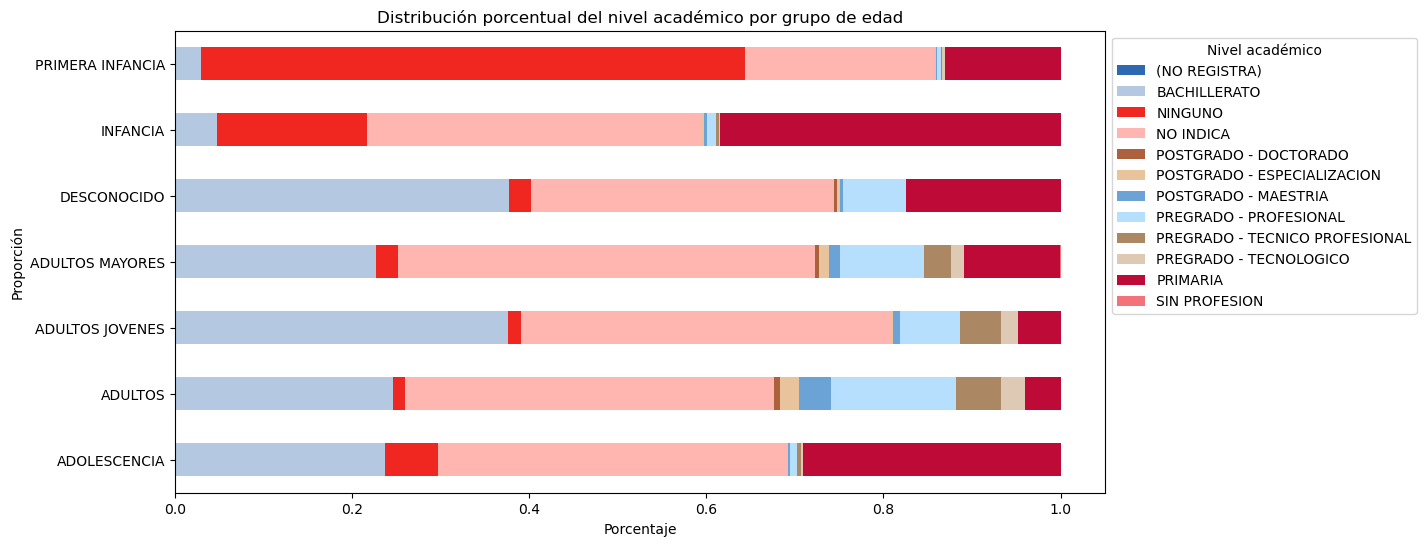

nivel_academico,(NO REGISTRA),BACHILLERATO,NINGUNO,NO INDICA,POSTGRADO - DOCTORADO,POSTGRADO - ESPECIALIZACION,POSTGRADO - MAESTRIA,PREGRADO - PROFESIONAL,PREGRADO - TECNICO PROFESIONAL,PREGRADO - TECNOLOGICO,PRIMARIA,SIN PROFESION
grupo_edad,,,,,,,,,,,,
ADOLESCENCIA,0.023%,23.691%,5.963%,39.531%,0.023%,0.046%,0.205%,0.751%,0.455%,0.205%,29.108%,0.000%
ADULTOS,0.052%,24.530%,1.439%,41.588%,0.729%,2.142%,3.576%,14.126%,5.100%,2.704%,4.002%,0.012%
ADULTOS JOVENES,0.040%,37.528%,1.538%,41.751%,0.048%,0.210%,0.734%,6.844%,4.631%,1.816%,4.853%,0.008%
ADULTOS MAYORES,0.055%,22.641%,2.504%,47.059%,0.449%,1.130%,1.200%,9.553%,2.995%,1.533%,10.862%,0.018%
DESCONOCIDO,0.000%,37.722%,2.491%,34.164%,0.356%,0.356%,0.356%,7.117%,0.000%,0.000%,17.438%,0.000%
INFANCIA,0.040%,4.735%,16.872%,37.883%,0.000%,0.199%,0.358%,0.955%,0.398%,0.080%,38.480%,0.000%
PRIMERA INFANCIA,0.000%,2.993%,61.347%,21.446%,0.000%,0.125%,0.125%,0.499%,0.125%,0.249%,13.092%,0.000%


In [19]:
cross = pd.crosstab(df_processing['grupo_edad'], df_processing['nivel_academico'], normalize='index')

cross.plot(kind='barh', stacked=True, figsize=(12,6), color=palette_custom)
plt.title('Distribución porcentual del nivel académico por grupo de edad')
plt.ylabel('Proporción')
plt.xlabel('Porcentaje')
plt.legend(title='Nivel académico', bbox_to_anchor=(1,1))
plt.show()

cross_dataframe = pd.DataFrame(cross)
tabla_porcentual_formato = cross_dataframe.style.format(
    lambda x: f"{(x * 100):.3f}%"
)
tabla_porcentual_formato

En el gráfico se observa que los grupos de adultos presentan un **alto porcentaje de personas cuyo nivel académico llega únicamente hasta “BACHILLERATO” o aparece como “NO INDICA”**. Esto sugiere que muchos adultos podrían estar viajando para buscar nuevas oportunidades laborales en otros países.

Además, se evidencia que los grupos **“ADULTOS”** y **“ADULTOS JÓVENES”** son quienes más viajan teniendo un **nivel académico alto**. A partir de esto, es posible inferir que las empresas extranjeras tienden a contratarlos con mayor frecuencia debido a su rango de edad y al nivel de experiencia que suelen poseer.
Aunque los **“ADULTOS MAYORES”** podrían contar con mayor trayectoria profesional, su rango de edad puede representar una desventaja competitiva en procesos de selección internacionales.

En conclusión, esta gráfica abre nuevas líneas de análisis y nos lleva a formular preguntas como:

* **¿Los adultos con alguna formación prefieren ciertos países?**
* **¿Los adultos sin formación prefieren ciertos paises?**

Estas preguntas se explorarán evaluando las columnas **'grupo_edad'**, **'nivel_academico'** y **'pais'**.


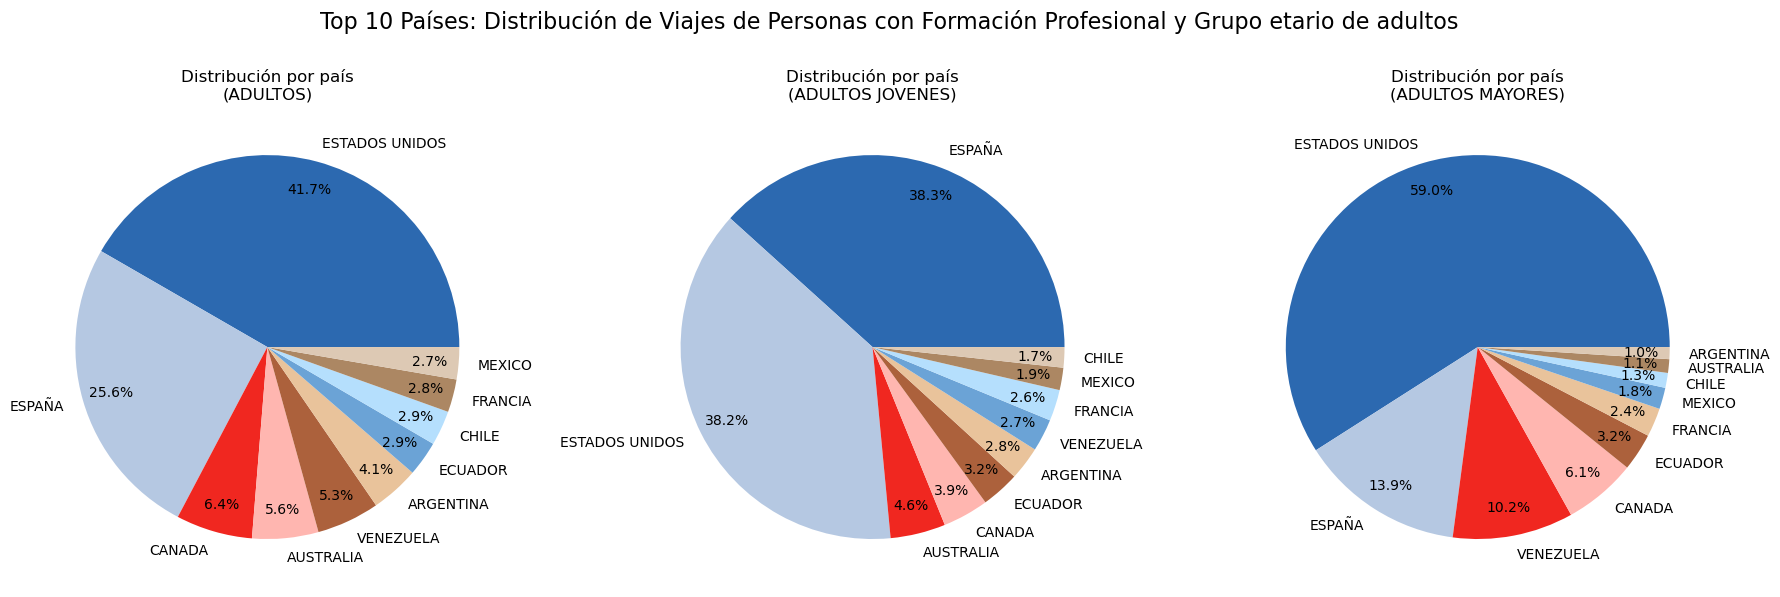

In [20]:
# Filtrado por las personas que tienen alguna formación academica
filtrado_formacion = df_processing[~df_processing['nivel_academico'].isin(['(NO REGISTRA)','BACHILLERATO', 'NO INDICA', 'NINGUNO', 'PRIMARIA', 'SIN PROFESION'])]

#Filtrado por los grupos de edades adultos
filtrado_grupo_edad = filtrado_formacion[filtrado_formacion['grupo_edad'].isin(['ADULTOS', 'ADULTOS JOVENES', 'ADULTOS MAYORES'])]

#Filtrado por el top 10 paises a los que mas viajan
top_10_paises = filtrado_grupo_edad['pais'].value_counts().head(10).index
data_adultos_con_formacion_profesional = filtrado_grupo_edad[filtrado_grupo_edad['pais'].isin(top_10_paises)]

grupos = ['ADULTOS', 'ADULTOS JOVENES', 'ADULTOS MAYORES']
plt.figure(figsize=(18, 6))

for i, grupo in enumerate(grupos, 1):
    subset = data_adultos_con_formacion_profesional[data_adultos_con_formacion_profesional['grupo_edad'] == grupo]
    conteos = subset['pais'].value_counts()
    
    plt.subplot(1, 3, i)
    plt.pie(conteos, labels=conteos.index, autopct='%1.1f%%', pctdistance=0.85, colors=palette_custom)
    plt.title(f'Distribución por país\n({grupo})')

plt.suptitle('Top 10 Países: Distribución de Viajes de Personas con Formación Profesional y Grupo etario de adultos', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


El análisis muestra que, entre los adultos con formación académica, los destinos migratorios mantienen patrones muy definidos:

1. **Estados Unidos es el destino predominante** en los tres grupos de edad, especialmente en adultos mayores.
2. **España ocupa el segundo lugar**, principalmente entre adultos jóvenes, impulsado por el idioma y las oportunidades laborales.
3. Otros países como **Canadá, Venezuela, Francia y Argentina** aparecen como destinos secundarios pero constantes.
4. **Los adultos mayores** concentran casi todos sus viajes en EE. UU. y España, lo que sugiere que migran por reunificación familiar.
5. En general, el nivel académico **no modifica significativamente el destino**, ya que la elección parece depender más de factores culturales, económicos y familiares.

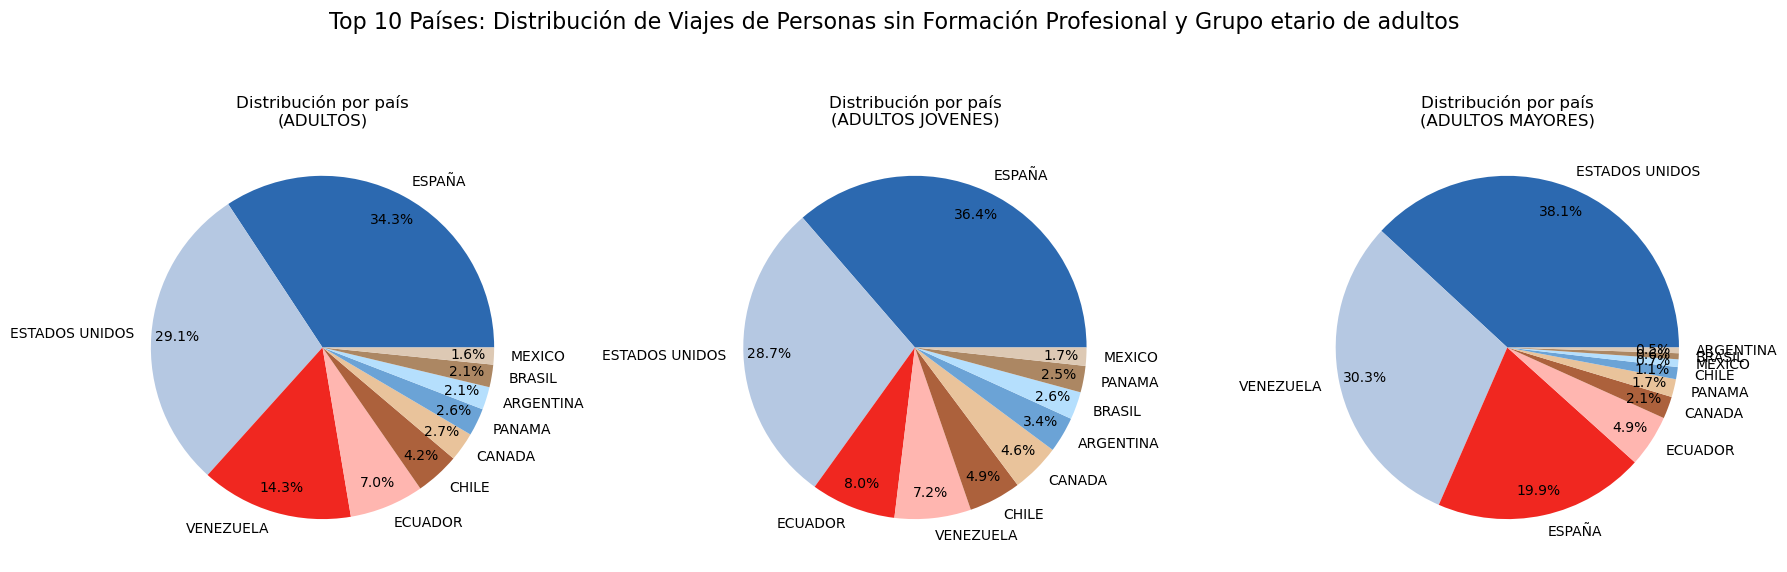

In [21]:
# Filtrado por las personas que no tienen alguna formación academica
filtrado_sin_formacion = df_processing[df_processing['nivel_academico'].isin(['BACHILLERATO', 'NO INDICA', 'NINGUNO', 'PRIMARIA', 'SIN PROFESION'])]

filtrado_grupo_edad = filtrado_sin_formacion[filtrado_sin_formacion['grupo_edad'].isin(['ADULTOS', 'ADULTOS JOVENES', 'ADULTOS MAYORES'])]

top_10_paises = filtrado_grupo_edad['pais'].value_counts().head(10).index
data_adultos_sin_formacion_profesional = filtrado_grupo_edad[filtrado_grupo_edad['pais'].isin(top_10_paises)]

grupos = ['ADULTOS', 'ADULTOS JOVENES', 'ADULTOS MAYORES']
plt.figure(figsize=(18, 6))

for i, grupo in enumerate(grupos, 1):
    subset = data_adultos_sin_formacion_profesional[data_adultos_sin_formacion_profesional['grupo_edad'] == grupo]
    conteos = subset['pais'].value_counts()
    
    plt.subplot(1, 3, i)
    plt.pie(conteos, labels=conteos.index, autopct='%1.1f%%', pctdistance=0.85, colors=palette_custom)
    plt.title(f'Distribución por país\n({grupo})')

plt.suptitle('Top 10 Países: Distribución de Viajes de Personas sin Formación Profesional y Grupo etario de adultos', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

El análisis de los destinos de adultos, adultos jóvenes y adultos mayores sin formación académica evidencia patrones migratorios muy definidos:

1. **España es el destino principal** en la mayoría de grupos, especialmente entre adultos jóvenes y adultos. Su preferencia puede relacionarse con el idioma y empleos accesibles sin requisitos educativos.
2. **Estados Unidos también mantiene una presencia fuerte**, siendo el destino más frecuente para adultos mayores. Esto sugiere motivaciones asociadas a reunificación familiar u oportunidades laborales básicas.
3. **Venezuela y Ecuador destacan como destinos relevantes**, sobre todo entre adultos mayores, lo que podría indicar principalmente migración circular y vínculos familiares.
4. En conjunto, los patrones muestran que las personas sin formación académica tienden a migrar hacia países donde existen **redes de apoyo** y **mayores facilidades de inserción laboral**, más que por factores educativos o profesionales.

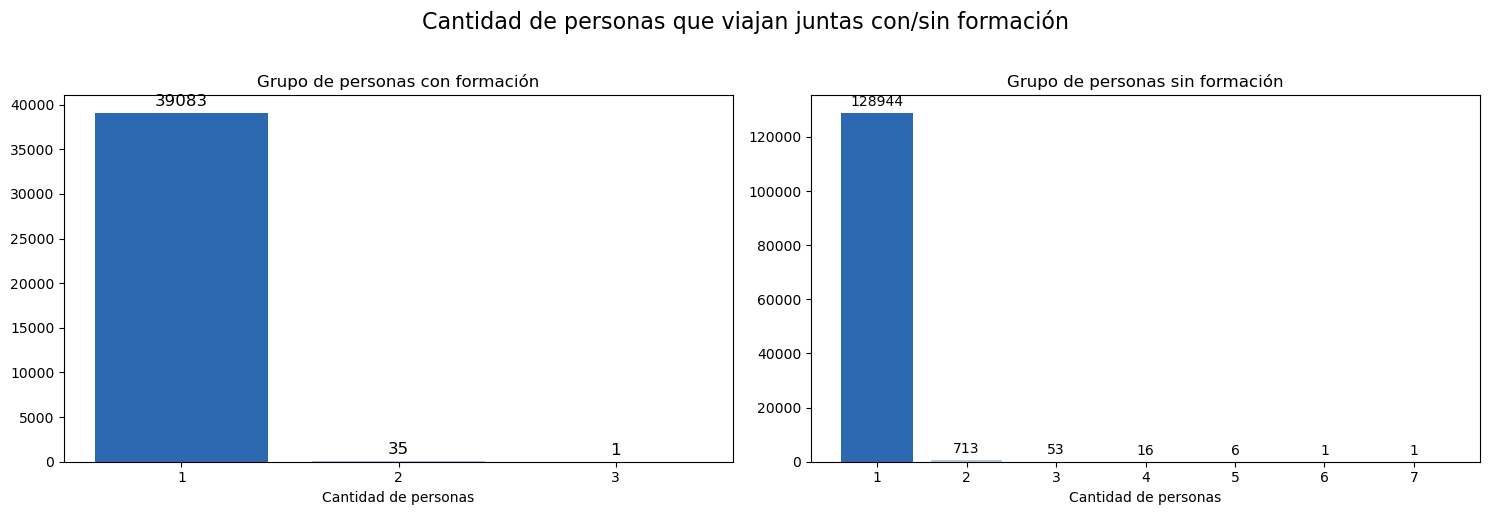

In [22]:
conteos_formacion = data_adultos_con_formacion_profesional['cantidad_de_personas'].astype(str).value_counts()
conteos_sin_formacion = data_adultos_sin_formacion_profesional['cantidad_de_personas'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
barras_1 = ax[0].bar(conteos_formacion.index, conteos_formacion.values, color=palette_custom)
ax[0].bar_label(barras_1, fmt='%d', padding=3, fontsize= 12)
ax[0].set_title('Grupo de personas con formación')
ax[0].set_xlabel('Cantidad de personas')

barras_2 = ax[1].bar(conteos_sin_formacion.index, conteos_sin_formacion.values, color=palette_custom)
ax[1].bar_label(barras_2, fmt='%d', padding=3)
ax[1].set_title('Grupo de personas sin formación')
ax[1].set_xlabel('Cantidad de personas')

plt.suptitle('Cantidad de personas que viajan juntas con/sin formación', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Un análisis adicional entre el **'nivel_academico'** y la **cantidad de personas que viajan juntas** (modalidad de viaje) nos permite establecer los siguientes patrones:

* **Tendencia General:** La migración a otros países se realiza predominantemente de **manera individual**.
* **Viajes Acompañados:** Se observa una ligera cantidad de viajeros que se desplazan en compañía, siendo los grupos de **dos personas** los más frecuentes sin alguna formación academica.
* **Conclusión:** Este hallazgo demuestra que la **formación académica** del viajero **no es un factor determinante** ni influye de manera significativa en la decisión de viajar solo o acompañado.

A continuación, cambiaremos el enfoque para analizar los grupos etarios no productivos: **primera infancia, infantes y adolescentes**. Se realizará una investigación para determinar si los **países de destino** preferidos por estos grupos cambian en comparación con los destinos de los adultos. Este análisis es clave porque los viajes de los menores suelen ser el resultado de:

* **Reunificación familiar** (viajando para encontrarse con sus padres o tutores).
* **Decisiones educativas** o de largo plazo tomadas por sus responsables.

El objetivo es ver si la variable **'grupo_edad'** en estos rangos más jóvenes genera un patrón de destino distinto en el *dataset*.

### Análisis grupo etario PRIMERA INFANCIA, INFANCIA Y ADOLESCENCIA

A continuación, cambiaremos el enfoque para analizar los grupos etarios no productivos: **primera infancia, infantes y adolescentes**. Se realizará una investigación para determinar si los **países de destino** preferidos por estos grupos cambian en comparación con los destinos de los adultos. Este análisis es clave porque los viajes de los menores suelen ser el resultado de:

* **Reunificación familiar** (viajando para encontrarse con sus padres o tutores).
* **Decisiones educativas** o de largo plazo tomadas por sus responsables.

El objetivo es ver si la variable **'grupo_edad'** en estos rangos más jóvenes genera un patrón de destino distinto en el *dataset*.

<Figure size 1000x1000 with 0 Axes>

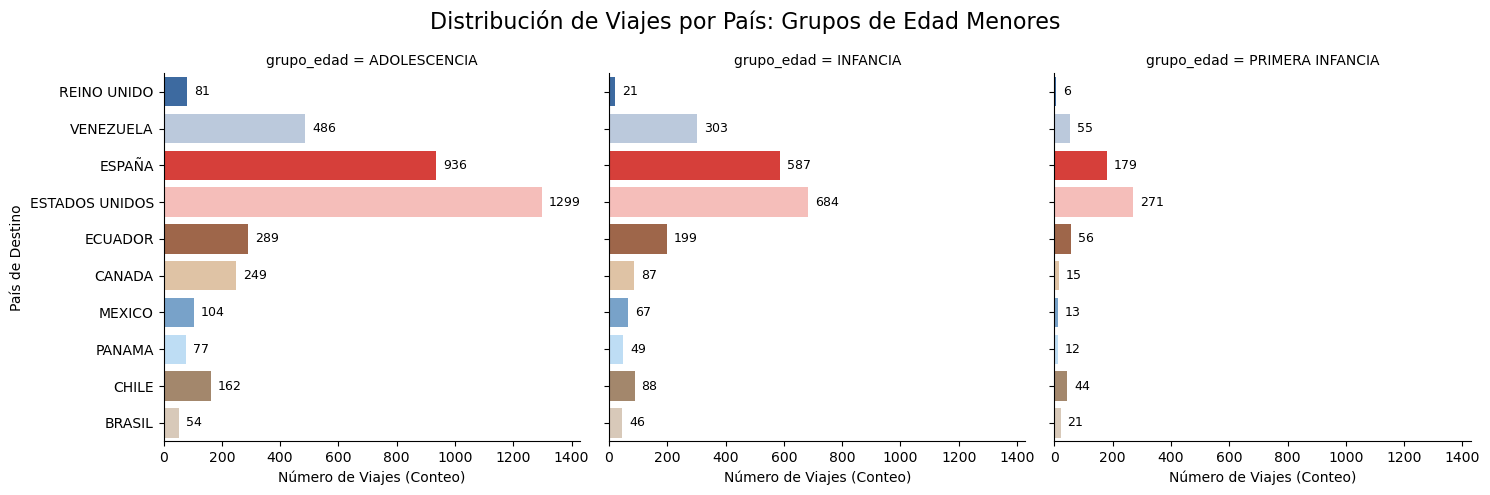

In [23]:
grupo_edad_menores = df_processing[df_processing['grupo_edad'].isin(['PRIMERA INFANCIA', 'INFANCIA', 'ADOLESCENCIA'])]
top_10_paises_menores = grupo_edad_menores['pais'].value_counts().head(10).index
data_grupo_menores = grupo_edad_menores[grupo_edad_menores['pais'].isin(top_10_paises_menores)]

palette = ajustar_palette(data_grupo_menores, 'pais', palette_custom)

fig = plt.figure(figsize=(10,10))
g = sns.catplot(data = data_grupo_menores, y = 'pais', kind='count', col= 'grupo_edad', hue = 'pais',palette=palette)

g.fig.suptitle("Distribución de Viajes por País: Grupos de Edad Menores", fontsize=16)
g.set_axis_labels(x_var="Número de Viajes (Conteo)", y_var="País de Destino")

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', padding=5, fontsize=9)
    ax.margins(x=0.1)

plt.tight_layout()
plt.show()

Vemos como no hay gran diferencia en los destinos preferidos por los grupos etarios de **primera infancia, infancia y adolescencia** en comparación con los adultos. Los destinos más populares siguen siendo los mismos que para los adultos: **Estados Unidos, España y Venezuela**. Con eso podemos inferir que los viajes de estos grupos etarios están fuertemente influenciados por las decisiones y circunstancias de sus familias, quienes probablemente eligen destinos basados en factores similares a los que motivan a los adultos a migrar.

Como última investigación, analizaremos la variable **'etnia_de_la_persona'** y la cruzaremos con los destinos de viaje. La hipótesis central es determinar si **diferencias culturales o de creencias** influyen de alguna manera en la elección del país de destino. Este análisis nos permitirá saber si grupos étnicos específicos muestran patrones de viaje preferenciales.

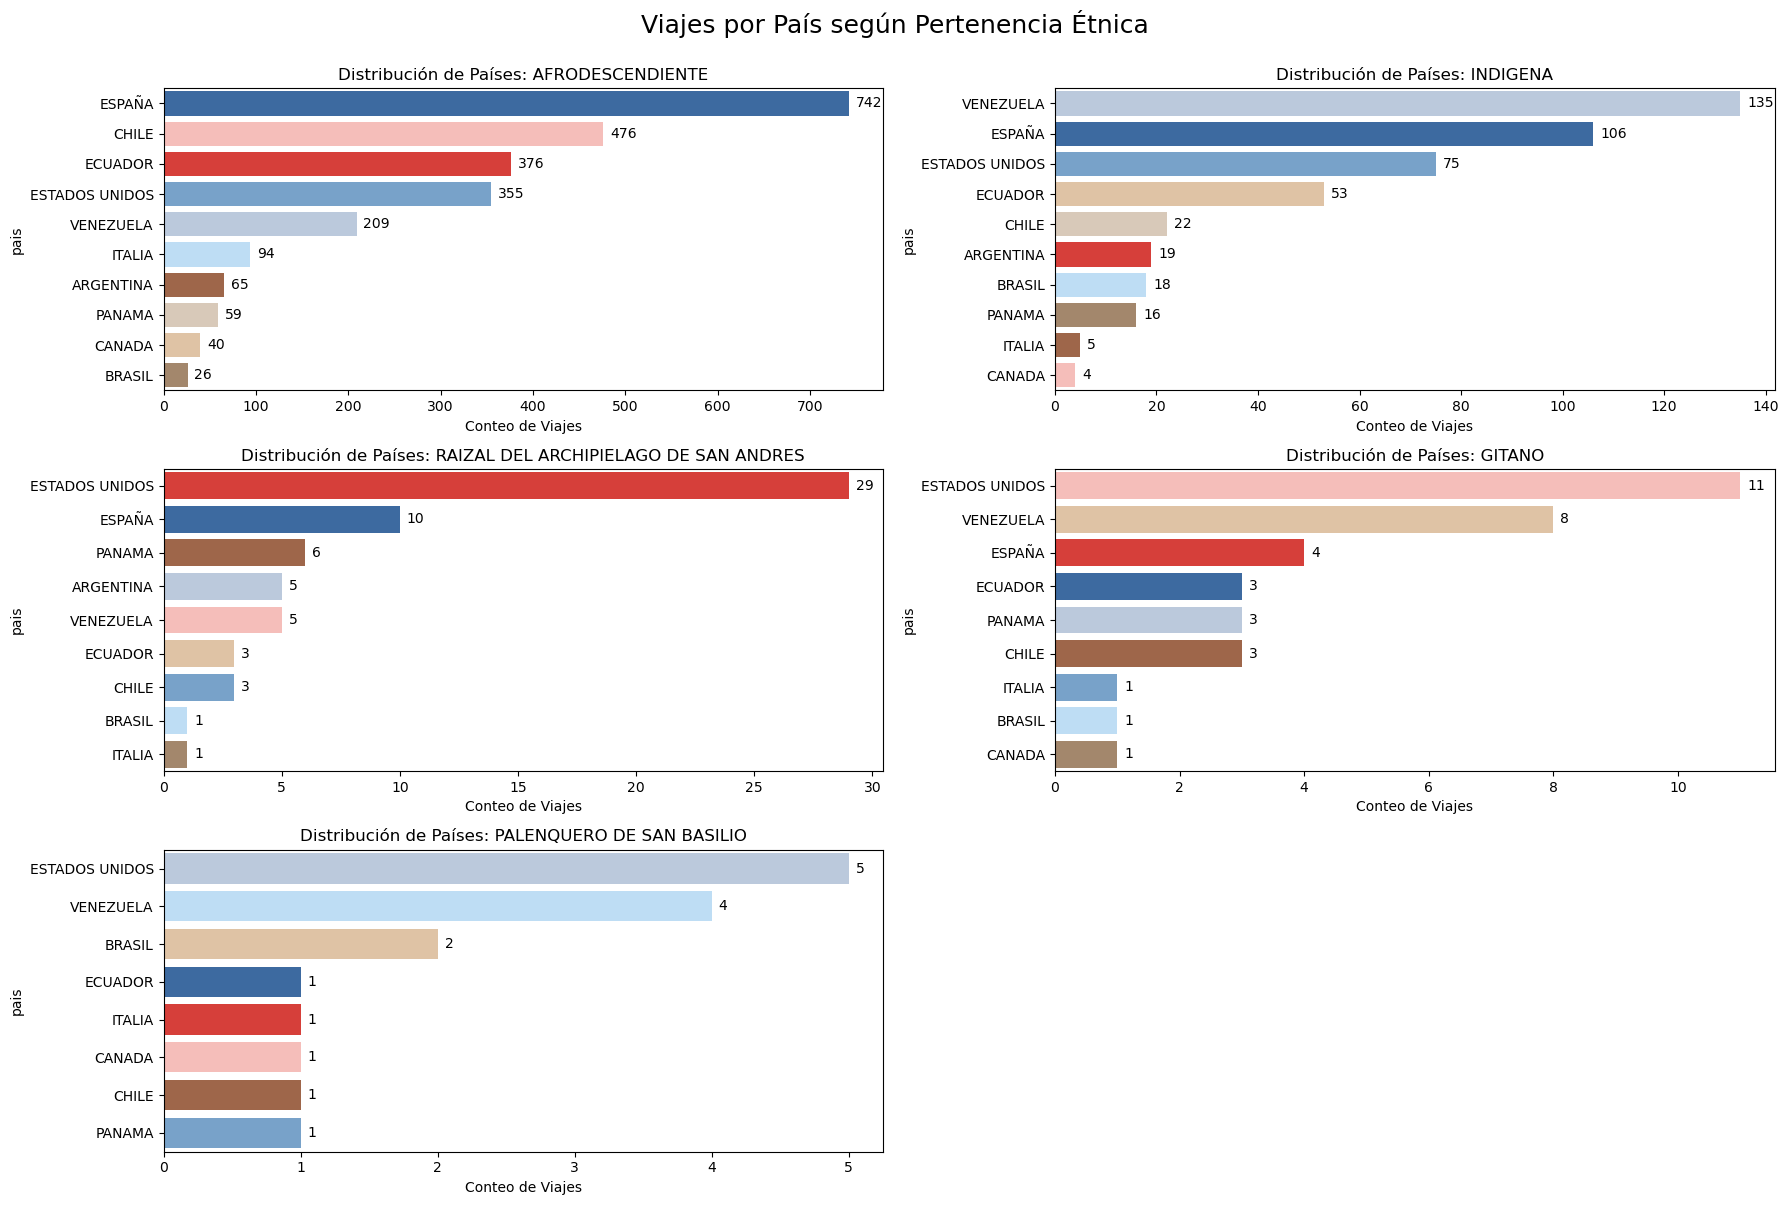

In [24]:
etnias_seleccionadas = df_processing[df_processing['etnia_de_la_persona'].isin(['AFRODESCENDIENTE', 'INDIGENA', 'RAIZAL DEL ARCHIPIELAGO DE SAN ANDRES', 'GITANO', 'PALENQUERO DE SAN BASILIO'])]
top_10_paises_etnias = etnias_seleccionadas['pais'].value_counts().head(10).index
data_etnia_de_la_persona = etnias_seleccionadas[etnias_seleccionadas['pais'].isin(top_10_paises_etnias)]

etnias = ['AFRODESCENDIENTE', 'INDIGENA', 'RAIZAL DEL ARCHIPIELAGO DE SAN ANDRES', 'GITANO', 'PALENQUERO DE SAN BASILIO']

fig, ax = plt.subplots(3, 2, figsize=(18, 12))
for etnia, current_ax in zip(etnias, ax.flatten()):

    subset = data_etnia_de_la_persona[data_etnia_de_la_persona['etnia_de_la_persona'] == etnia]
    palettes = ajustar_palette(subset, 'pais', palette_custom)
    
    sns.countplot(data=subset, y='pais', ax=current_ax, order=subset['pais'].value_counts().index, palette=palettes, hue ='pais')
    
    for container in current_ax.containers:
        current_ax.bar_label(container, fmt='%d', padding=5, fontsize=10)

    current_ax.set_title(f"Distribución de Países: {etnia}", fontsize=12)
    current_ax.set_xlabel("Conteo de Viajes")

ax.flatten()[-1].set_visible(False)
plt.suptitle("Viajes por País según Pertenencia Étnica", fontsize=18, y=1.0)
plt.tight_layout()
plt.show()

El análisis de la columna **'etnia_de_la_persona'** y su cruce con los destinos de viaje revela que la pertenencia étnica **sí introduce variaciones** en los patrones migratorios colombianos. A continuación, se resumen las conclusiones clave:

* **Afrodescendientes: El Grupo más Móvil:**
    El grupo **Afrodescendiente** registra, con diferencia, el **volumen más alto de viajes** y la mayor diversificación de destinos. Su principal elección es **España**, lo que sugiere una fuerte dependencia de las **migratorias** ya establecidas en ese país, facilitadas por el idioma.

* **Destinos Centrales Comunes:**
    A pesar de las variaciones étnicas, **España, Estados Unidos y Venezuela** se mantienen como los destinos más frecuentes para **todos los grupos** de la muestra.

* **Movilidad del Grupo Indígena:**
    La población **Indígena** muestra una movilidad moderada, con una fuerte preferencia hacia **Venezuela y España**, lo que por un lado se explica por la **proximidad geográfica** y por el otro, la facilidad del idioma.

* **Patrones de Minorías:**
    Los grupos étnicos minoritarios (Raizales, Gitanos, Palenqueros) registran volúmenes de viaje bajos, pero muestran una preferencia por **Estados Unidos y Venezuela**, lo que indica que sus viajes están ligados a **nichos laborales específicos** o a la **reunificación familiar**.

La preferencia por el destino final está determinada por una **combinación de factores**. Si bien los motivos de migración (laboral o familiar) son generales, las **dinámicas culturales específicas** y las **redes de apoyo social** de cada etnia influyen de manera clara en la elección del país, siendo la preferencia por España en el grupo Afrodescendiente un ejemplo destacado.

## 📝 Conclusiones Generales del Análisis Exploratorio

El análisis de los patrones de viaje de los colombianos al exterior permite establecer varias conclusiones fundamentales sobre el perfil del migrante y los factores que determinan la elección del destino:

### 1. El Perfil del Viajero Dominante: El Adulto Productivo

El análisis univariado del **grupo etario** confirma que la **población adulta en edad productiva** (ADULTOS JOVENES, ADULTOS Y ADULTOS MAYORES) concentra el mayor flujo de viajes. Este hallazgo establece que la migración colombiana está fuertemente orientada a la **búsqueda de oportunidades** o al desarrollo de actividades laborales.

### 2. Motivación y Formación: Un Patrón Dual

La migración adulta obedece a un patrón dual influenciado por el nivel académico:

* **Migración por Oportunidad:** Los adultos con **formación académica cualificada** viajan con una alta frecuencia, probablemente motivados por mejores ofertas laborales y desarrollo profesional en el exterior.
* **Migración por Necesidad:** Existe un flujo significativo de adultos con **baja formación**, lo que sugiere que la migración es una respuesta a la **falta de oportunidades** o flexibilidad laboral en el país de origen.

### 3. La Influencia de los Lazos Familiares y Culturales

* **Reunificación Familiar:** Los patrones de destino de los grupos etarios extremos (**primera infancia, infantes, adolescentes y adultos mayores**) son casi idénticos a los de los adultos productivos. Esto indica que la **reunificación familiar** es un factor determinante y transversal en la decisión de migrar.
* **Modalidad de Viaje:** La **modalidad de viaje es predominantemente individual**, y esta decisión no está correlacionada con el nivel de formación académica del viajero.

### 4. Destino: La Etnia como Factor Diferencial

Si bien **Estados Unidos, España y Venezuela** son los destinos preferidos en la mayoría de las categorías, el factor **étnico introduce matices** importantes:

* **España** es el destino principal para el grupo **Afrodescendiente**, demostrando que las **redes sociales y culturales** de la etnia tienen un peso significativo en la elección del país de asentamiento.
* La **proximidad geográfica** influye notablemente en el grupo **Indígena**, que prioriza destinos fronterizos como Venezuela y Ecuador.

---

## 📊 Visualización Interactiva y Resultados Finales: Dashboard en Power BI

Como **resultado final** de este análisis de datos, se desarrolló un **Dashboard interactivo en Power BI**, titulado **"Migración Internacional – Comportamiento por Mes, Año y Grupo Etario"** . Esta herramienta tiene como objetivo principal facilitar la exploración dinámica de los patrones migratorios colombianos, permitiendo a cualquier usuario profundizar en los datos analizados.

El Dashboard incluye las siguientes funcionalidades clave para la exploración interactiva:

* **Distribución Temporal y Estacionalidad:** La sección **"Total de personas por mes y país"** permite visualizar de forma inmediata los picos y valles de los flujos migratorios a lo largo del año, crucial para identificar la estacionalidad.
* **Filtros Dinámicos de Variables Clave:** La herramienta ofrece una segmentación completa, permitiendo filtrar y consultar la información basándose en las variables más relevantes del estudio:
    * **Tiempo:** Filtrado por **Año** (desde 2012 hasta 2025).
    * **Población:** Segmentación por **Grupo Etario** (Adolescencia, Adultos, Adultos Jóvenes, etc.).
    * **Geografía:** Filtrado por **País y Ciudad de Residencia**.
* **Métricas Resumen:** Incluye tarjetas clave como el **"Total de registros filtrados"** (ejemplo: 200 mil) y tablas de **"Edad promedio por mes y género"**, que añaden una capa de detalle a los análisis de tendencia.

**Valor Añadido:** Este Dashboard transforma el análisis exploratorio en una herramienta de consulta ágil y detallada, que permite a los usuarios **validar las conclusiones del proyecto** y responder a preguntas específicas sobre la estacionalidad y la evolución de los patrones migratorios a lo largo del tiempo.

**Con esto se concluye el proyecto de análisis exploratorio sobre los patrones de viaje de los colombianos al exterior.**